# Introduction

Notebook to aggregate the running of models in the context of traceability between **features** and **bug reports**.

# Load Libraries and Datasets

In [1]:
from mod_finder_util import mod_finder_util
mod_finder_util.add_modules_origin_search_path()

from modules.models_runner import feat_br_strat_runner

import warnings; warnings.simplefilter('ignore')

# Run All Models

## Volunteers Only Strategy

In [2]:
vol_strat_runner = feat_br_strat_runner.Feat_BR_Vol_Strat_Runner()
vol_strat_runner.execute()

evaluator_4 = vol_strat_runner.get_evaluator() 
evals_df_4 = vol_strat_runner.get_evals_df()

Feat_BR Volunteers Matrix shape: (91, 19)
Features.shape: (19, 8)
SelectedBugReports.shape: (91, 18)
Running LSI model -----
Running LDA model -----
Running BM25 model -----
Running W2V model -----
Evaluating LSI Model ----- 
Evaluating LDA Model ----- 
Evaluating BM25 Model ----- 
Evaluating WORDVECTOR Model ----- 


### Results

In [3]:
evals_df_4.head()

,model,ref_name,perc_precision,perc_recall,perc_fscore,eval_df,sim_threshold,top,trace_links_df
0,lsi,top_1_cosine_0.0,28.57,26.18,26.62,precision recall fscore Bug_Nu...,0.0,1.0,Bug_Number 1248267 1248268 125...
1,lsi,top_3_cosine_0.0,18.32,47.31,25.23,precision recall fscore Bug_Nu...,0.0,3.0,Bug_Number 1248267 1248268 125...
2,lsi,top_5_cosine_0.0,12.53,52.06,19.24,precision recall fscore Bug_Nu...,0.0,5.0,Bug_Number 1248267 1248268 125...
3,lsi,top_10_cosine_0.0,7.91,60.94,13.32,precision recall fscore Bug_...,0.0,10.0,Bug_Number 1248267 1248268 125...
4,lsi,top_12_cosine_0.0,7.05,64.28,12.14,precision recall fscore Bug_...,0.0,12.0,Bug_Number 1248267 1248268 125...


In [4]:
from modules.utils import aux_functions

aux_functions.highlight_df( evals_df_4[['model','perc_precision','perc_recall','perc_fscore','top']].groupby(['model','top']).mean())

### Plots

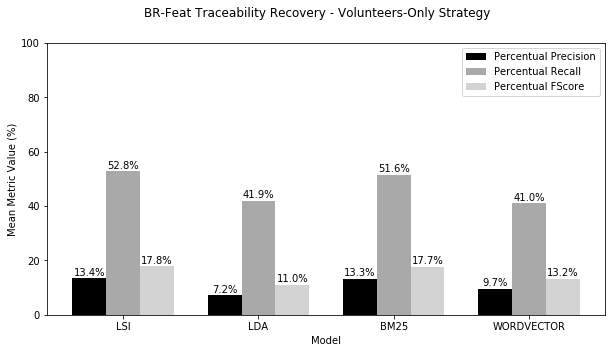

In [5]:
evaluator_4.plot_evaluations_3(evals_df_4, title='BR-Feat Traceability Recovery - Volunteers-Only Strategy')

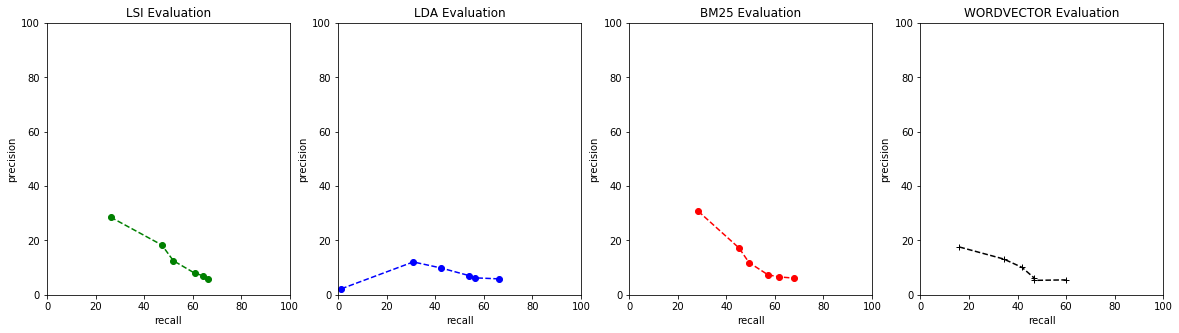

In [6]:
evaluator_4.plot_evaluations_4(evals_df_4)

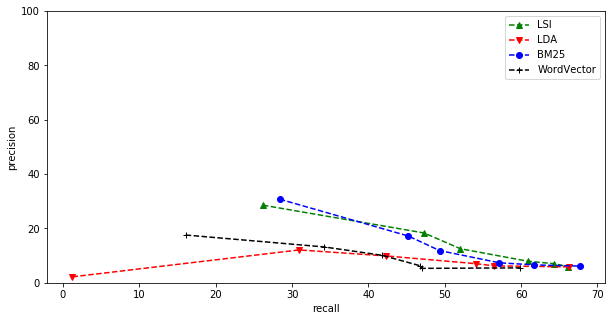

In [7]:
evaluator_4.plot_evaluations_5(evals_df_4)

In [8]:
evals_df_4[(evals_df_4.ref_name == 'top_{}_cosine_{}'.format(1,0.0)) & (evals_df_4.model == 'lsi')]

,model,ref_name,perc_precision,perc_recall,perc_fscore,eval_df,sim_threshold,top,trace_links_df
0,lsi,top_1_cosine_0.0,28.57,26.18,26.62,precision recall fscore Bug_Nu...,0.0,1.0,Bug_Number 1248267 1248268 125...


### Retrieved Traces

In [10]:
models = ['lsi','lda','bm25','wordvector']
tops = [1,3,5,10,12,15]
#cosines = [0.0, 0.9]
cosines = [0.0]

for m in models:
    for top in tops:
        for cos in cosines:
            df = evals_df_4[(evals_df_4.ref_name == 'top_{}_cosine_{}'.format(top,cos)) & (evals_df_4.model == m)].iloc[0,:]
            trace_links = df.trace_links_df
            p = df.perc_precision
            r = df.perc_recall
            relevant = len(aux_functions.get_true_positives(oracle_df=vol_strat_runner.get_oracle(), output_df = trace_links))
            retrieved = sum([trace_links[col].sum() for col in trace_links.columns])
            print('retrieved: {:>4} - relevant: {:>4} - (m={:>12}, t={:>2}, c={:>2.2}) - prec: {:>5.4} - recall : {:>5.4}'.format(retrieved,relevant,m,top,cos,p,r))

retrieved:   91 - relevant:   26 - (m=         lsi, t= 1, c=0.0) - prec: 28.57 - recall : 26.18
retrieved:  273 - relevant:   50 - (m=         lsi, t= 3, c=0.0) - prec: 18.32 - recall : 47.31
retrieved:  455 - relevant:   57 - (m=         lsi, t= 5, c=0.0) - prec: 12.53 - recall : 52.06
retrieved:  910 - relevant:   72 - (m=         lsi, t=10, c=0.0) - prec:  7.91 - recall : 60.94
retrieved: 1092 - relevant:   77 - (m=         lsi, t=12, c=0.0) - prec:  7.05 - recall : 64.28
retrieved: 1365 - relevant:   81 - (m=         lsi, t=15, c=0.0) - prec:  5.93 - recall :  66.2
retrieved:   91 - relevant:    2 - (m=         lda, t= 1, c=0.0) - prec:   2.2 - recall :  1.24
retrieved:  273 - relevant:   33 - (m=         lda, t= 3, c=0.0) - prec: 12.09 - recall : 30.93
retrieved:  455 - relevant:   45 - (m=         lda, t= 5, c=0.0) - prec:  9.89 - recall : 42.28
retrieved:  910 - relevant:   64 - (m=         lda, t=10, c=0.0) - prec:  7.03 - recall : 54.09
retrieved: 1092 - relevant:   68 - (m=  

### Delete Variables

## Union Strategy

In [ ]:
exp_vol_union_strat_runner = feat_br_strat_runner.Feat_BR_Exp_Vol_Union_Strat_Runner()
exp_vol_union_strat_runner.execute()

evaluator_1 = exp_vol_union_strat_runner.get_evaluator() 
evals_df_1 = exp_vol_union_strat_runner.get_evals_df()

### Results

In [ ]:
evals_df_1.head()

In [ ]:
evaluator_1.plot_evaluations_4(evals_df_1)

In [ ]:
evaluator_1.plot_evaluations_5(evals_df_1)

### Plots

In [ ]:
evaluator_1.plot_evaluations_3(evals_df_1, title='BR-Feat Traceability Recovery - Exp-Vol Union Strategy')

### Delete Variables

## Intersec Strategy

In [ ]:
exp_vol_intersec_strat_runner = feat_br_strat_runner.Feat_BR_Exp_Vol_Intersec_Strat_Runner()
exp_vol_intersec_strat_runner.execute()

evaluator_2 = exp_vol_intersec_strat_runner.get_evaluator() 
evals_df_2 = exp_vol_intersec_strat_runner.get_evals_df()

### Results

In [ ]:
evals_df_2.head()

### Plots

In [ ]:
evaluator_2.plot_evaluations_3(evals_df_2, title='BR-Feat Traceability Recovery - Exp-Vol Intersec Strategy')

In [ ]:
evaluator_2.plot_evaluations_4(evals_df_2)

In [ ]:
evaluator_2.plot_evaluations_5(evals_df_2)

### Delete Variables

## Expert Only Strategy

In [ ]:
exp_strat_runner = feat_br_strat_runner.Feat_BR_Exp_Strat_Runner()
exp_strat_runner.execute()

evaluator_3 = exp_strat_runner.get_evaluator() 
evals_df_3 = exp_strat_runner.get_evals_df()

### Results

In [ ]:
evals_df_3.head()

### Plots

In [ ]:
evaluator_3.plot_evaluations_3(evals_df_3, title='BR-Feat Traceability Recovery - Expert-Only Strategy')

In [ ]:
evaluator_3.plot_evaluations_4(evals_df_3)

In [ ]:
evaluator_3.plot_evaluations_5(evals_df_3)

### Delete Variables